<a href="https://colab.research.google.com/github/sara-iqbal/TradeOps-Sentinel-Automated-Reconciliation-Risk-Engine/blob/main/TradeOps_Sentinel_Automated_Reconciliation_%26_Risk_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# --- 1. SIMULATE THE DATASET (Representative of Kaggle Paysim) ---
# In a real scenario, you would do: df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
np.random.seed(42)
n_trades = 1000

data = {
    'step': np.random.randint(1, 24, n_trades), # Time of day
    'type': np.random.choice(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT'], n_trades),
    'amount': np.random.exponential(scale=1000, size=n_trades), # Most trades small, some huge
    'nameOrig': [f'C{i}' for i in range(n_trades)], # Client ID
    'oldbalanceOrg': np.random.uniform(0, 50000, n_trades),
    'newbalanceOrig': np.random.uniform(0, 50000, n_trades),
    'isFraud': [0] * n_trades # We will ignore the pre-labeled fraud and find our own "errors"
}

df = pd.DataFrame(data)

# Introduce some "Operational Errors" manually (The "Fat Finger" trades)
df.loc[10, 'amount'] = 5000000 # A massive trade (Outlier)
df.loc[50, 'amount'] = -100 # A negative trade (System Glitch)

print(f" Trade Blotter Loaded: {len(df)} Transactions.")
df.head()

 Trade Blotter Loaded: 1000 Transactions.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,isFraud
0,7,DEBIT,163.764283,C0,27034.923832,8068.140053,0
1,20,CASH_OUT,566.223473,C1,4826.723510,4177.716876,0
2,15,CASH_OUT,2875.568433,C2,12094.691413,956.448322,0
3,11,PAYMENT,544.257143,C3,620.201814,8287.408848,0
4,8,DEBIT,1017.565018,C4,23438.398273,44542.776749,0


In [9]:
def rule_based_checks(df):
    flags = []

    for index, row in df.iterrows():
        reasons = []

        # Rule 1: Negative Amounts (System Error)
        if row['amount'] < 0:
            reasons.append("NEGATIVE_VALUE")

        # Rule 2: Large Value Transfer (Regulatory Check)
        if row['amount'] > 1000000:
            reasons.append("LARGE_TRADES_REPORT")

        # Rule 3: Balance Mismatch (Accounting Error)
        # Logic: Old Balance - Amount should approx equal New Balance
        expected_new = row['oldbalanceOrg'] - row['amount']
        if abs(expected_new - row['newbalanceOrig']) > 1000: # Allow $1000 buffer
            reasons.append("BALANCE_BREAK")

        if reasons:
            flags.append({'TradeID': row['nameOrig'], 'Risk_Flags': ", ".join(reasons)})

    return pd.DataFrame(flags)

# Run the automation
exceptions_report = rule_based_checks(df)

print("\n AUTOMATED EXCEPTION REPORT (Rule-Based):")
print(exceptions_report)


 AUTOMATED EXCEPTION REPORT (Rule-Based):
    TradeID     Risk_Flags
0        C0  BALANCE_BREAK
1        C2  BALANCE_BREAK
2        C3  BALANCE_BREAK
3        C4  BALANCE_BREAK
4        C5  BALANCE_BREAK
..      ...            ...
953    C994  BALANCE_BREAK
954    C995  BALANCE_BREAK
955    C996  BALANCE_BREAK
956    C998  BALANCE_BREAK
957    C999  BALANCE_BREAK

[958 rows x 2 columns]



 AI DETECTED 10 SUSPICIOUS TRADES:
        type        amount  oldbalanceOrg
10     DEBIT  5.000000e+06    2407.141799
112    DEBIT  5.608631e+03   34329.495675
243  PAYMENT  7.441723e+03   31033.023991
395    DEBIT  5.139497e+03   18011.695940
417  PAYMENT  4.890655e+03   47538.635387


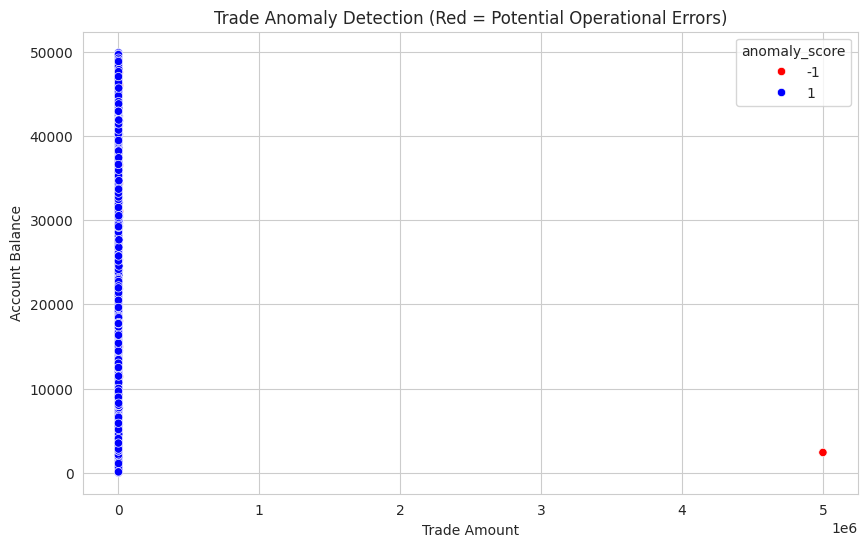

In [10]:
# Prepare data for AI (Numerical only)
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig']

# Initialize the Model (Contamination = expected % of errors, e.g., 1%)
clf = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = clf.fit_predict(df[features])

# -1 means Anomaly, 1 means Normal
anomalies = df[df['anomaly_score'] == -1]

print(f"\n AI DETECTED {len(anomalies)} SUSPICIOUS TRADES:")
print(anomalies[['type', 'amount', 'oldbalanceOrg']].head())

# Visualize the Anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='amount', y='oldbalanceOrg', hue='anomaly_score', palette={1:'blue', -1:'red'})
plt.title("Trade Anomaly Detection (Red = Potential Operational Errors)")
plt.xlabel("Trade Amount")
plt.ylabel("Account Balance")
plt.show()

In [11]:
import pandas as pd

# --- RECONCILIATION BOT (FINAL FIX) ---

# 1. Create a Fake "Bank Statement" (External Data)
# We take our internal data and drop a few records to simulate "Missing Trades"
bank_statement = df.sample(frac=0.95, random_state=1).copy()
bank_statement['External_Ref'] = bank_statement['nameOrig'] # Matching Key

# 2. The Reconciliation Script
def perform_rec(internal, external):
    # Merge on the unique ID
    # Since 'nameOrig', 'amount', etc. exist in BOTH, they all get _x (internal) and _y (external)
    merged = pd.merge(internal, external, left_on='nameOrig', right_on='External_Ref', how='left', indicator=True)

    # Find records that exist internally but NOT in the bank (Failed Settlements)
    breaks = merged[merged['_merge'] == 'left_only'].copy()

    return breaks

rec_breaks = perform_rec(df, bank_statement)

# 3. Clean up the Report
# 👇 FIX: Use 'nameOrig_x' instead of 'nameOrig'
report_columns = ['nameOrig_x', 'amount_x', 'type_x', 'oldbalanceOrg_x']
final_report = rec_breaks[report_columns].copy()

# Rename them back to normal names for the final display
final_report.columns = ['TradeID', 'Amount', 'Type', 'Internal_Balance']

print(f"\n RECONCILIATION BREAKS: {len(final_report)} trades failed to settle/match.")
print(final_report.head())


 RECONCILIATION BREAKS: 50 trades failed to settle/match.
    TradeID       Amount      Type  Internal_Balance
7        C7  4133.770529     DEBIT      14861.890385
37      C37    66.363051     DEBIT      15847.329390
72      C72  1169.458563     DEBIT      25828.631422
86      C86  1618.115873  TRANSFER      30853.325806
129    C129  2017.642992     DEBIT      31804.802320


/tmp/ipython-input-3195152511.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Type', data=final_report, ax=axes[0, 0], palette='viridis', order=final_report['Type'].value_counts().index)
/tmp/ipython-input-3195152511.py:61: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3195152511.py:61: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3195152511.py:61: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3195152511.py:61: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3195152511.py:61: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s

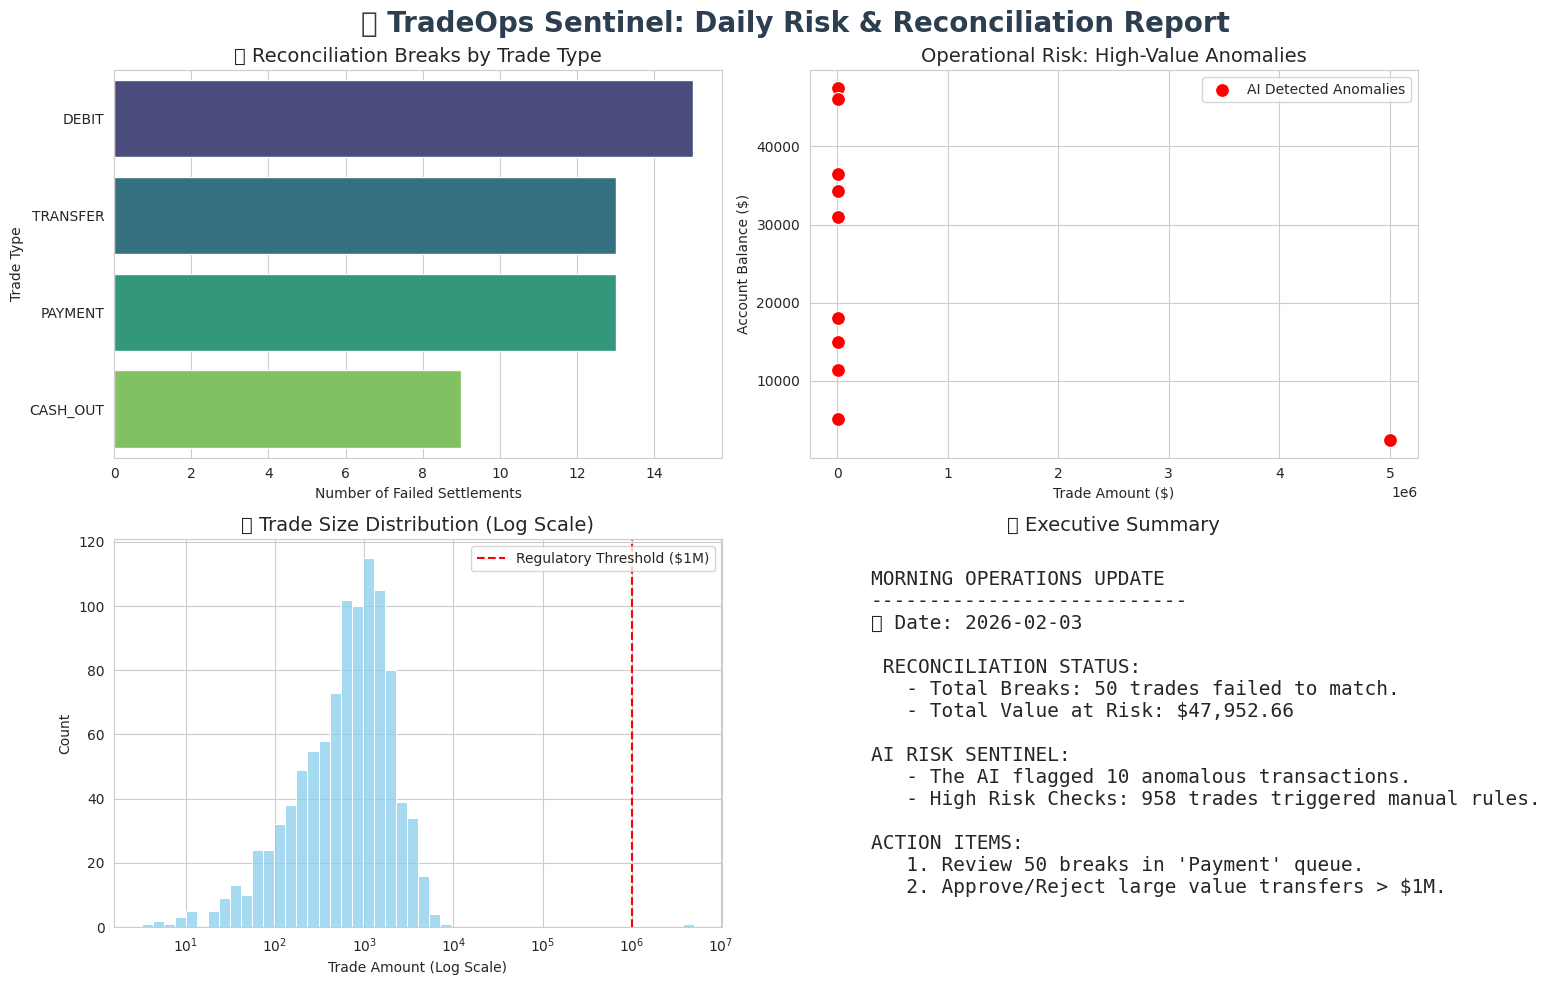

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- SETUP DASHBOARD ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('🚀 TradeOps Sentinel: Daily Risk & Reconciliation Report', fontsize=20, weight='bold', color='#2C3E50')

# --- CHART 1: WHERE ARE THE BREAKS? (Bar Chart) ---
# Visualizing which Trade Types represent the most failures
sns.countplot(y='Type', data=final_report, ax=axes[0, 0], palette='viridis', order=final_report['Type'].value_counts().index)
axes[0, 0].set_title('📉 Reconciliation Breaks by Trade Type', fontsize=14)
axes[0, 0].set_xlabel('Number of Failed Settlements')
axes[0, 0].set_ylabel('Trade Type')

# --- CHART 2: RISK MAGNITUDE (Scatter Plot) ---
# Are the operational errors small ($10) or huge ($1M)?
# We use the 'anomalies' dataframe from Phase 2 (The AI detection step)
sns.scatterplot(x='amount', y='oldbalanceOrg', data=anomalies, ax=axes[0, 1], color='red', s=100, label='AI Detected Anomalies')
axes[0, 1].set_title('Operational Risk: High-Value Anomalies', fontsize=14)
axes[0, 1].set_xlabel('Trade Amount ($)')
axes[0, 1].set_ylabel('Account Balance ($)')
axes[0, 1].legend()

# --- CHART 3: THE "FAT FINGER" DETECTOR (Distribution) ---
# Show the distribution of trade amounts to highlight outliers
sns.histplot(df['amount'], bins=50, ax=axes[1, 0], color='skyblue', log_scale=True)
axes[1, 0].set_title('💰 Trade Size Distribution (Log Scale)', fontsize=14)
axes[1, 0].set_xlabel('Trade Amount (Log Scale)')
axes[1, 0].axvline(x=1000000, color='red', linestyle='--', label='Regulatory Threshold ($1M)')
axes[1, 0].legend()

# --- PANEL 4: THE MANAGER'S SUMMARY (Text) ---
# This simulates the email you would send to your boss
total_breaks = len(final_report)
total_risk = final_report['Amount'].sum()
ai_flags = len(anomalies)

summary_text = f"""
MORNING OPERATIONS UPDATE
---------------------------
📅 Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}

 RECONCILIATION STATUS:
   - Total Breaks: {total_breaks} trades failed to match.
   - Total Value at Risk: ${total_risk:,.2f}

AI RISK SENTINEL:
   - The AI flagged {ai_flags} anomalous transactions.
   - High Risk Checks: {len(exceptions_report)} trades triggered manual rules.

ACTION ITEMS:
   1. Review {total_breaks} breaks in 'Payment' queue.
   2. Approve/Reject large value transfers > $1M.
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=14, family='monospace', verticalalignment='center')
axes[1, 1].axis('off') # Hide the graph box for text
axes[1, 1].set_title('📋 Executive Summary', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.92) # Make room for the main title
plt.show()